In [1]:
import uavgeo as ug
import geopandas as gpd
import rioxarray
import numpy as np
import ultralytics
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# pix2pix result analysis

1. Data loading and resetting to geographic coordinates using the test-splits
2. Visualizing the correlation of epoch200 vs real (with density)
3. Visualizing the epoch improvements
4. Visualizing rgb-true-p2p_e200 

In [2]:
# load the datasplits 
test = gpd.read_file("botrytis_data/p2p_geoms/test.geojson")

# load the orthomosaic 
ortho = rxr.open_rasterio("botrytis_data/ortho_etrs89.tif",nodata = 65535, mode = "w", dtype= np.uint16)
ndvi = ug.compute.calc_ndvi(ortho,red_id =3, nir_id=4, rescale= True)

#split the ndvi raster to acquire the boundaries, xylims etc.
test_rgbs = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in test.iterrows()]


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [3]:
import re

def check_pattern_matches(pattern, string_list):
    matched_strings = []
    for string in string_list:
        if re.search(pattern, string):
            matched_strings.append(string)
    return matched_strings


## 1. Reconstruct the longest imagery from the 200th epoch results

In [4]:
#Reconstruct an epoch that has passed thorugh p2p
sub = "test_200"
folder = os.path.join("rgb_ndvi_p2p", sub, "images")

fakeb = "fake_B"
realb = "real_B"
reala = "real_A"

        
imgs = [os.path.join(img) for img in os.listdir(folder)]
real_a =[os.path.join(folder, file) for file in check_pattern_matches(reala, imgs)]
real_b = [os.path.join(folder, file) for file in check_pattern_matches(realb, imgs)]
fake_b = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]
         

In [5]:
# load them as images

import numpy as np
from PIL import Image

def image_to_numpy_array(image_path):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    numpy_array = np.array(image)

    return numpy_array
real_a_arr =[image_to_numpy_array(file) for file in real_a]
real_b_arr = [image_to_numpy_array(file) for file in real_b]
fake_b_arr = [image_to_numpy_array(file) for file in fake_b]
         

In [6]:
# empty rgb array from ortho:

empty_rgb = xr.full_like(ortho.sel(band=[1,2,3]), fill_value=np.nan)
empty_ndvi = xr.full_like(ndvi, fill_value=np.nan)


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


In [7]:
def np_chip_to_rxr(darray, geom, crs):

    min_x, min_y, max_x, max_y = geom.geometry.bounds
    
    x_coords = np.linspace(min_x, max_x, darray.shape[1])
    y_coords =np.linspace(min_y, max_y, darray.shape[0])[::-1]
    #darray = np.rot90(darray)
    return xr.DataArray(darray, dims=("y", "x", "band"), coords={"x": x_coords, "y": y_coords}).rio.write_crs(crs).transpose('band', 'y', 'x')


In [8]:
from rioxarray import merge

rgb_test_list = [np_chip_to_rxr(real_a_arr[i], row, test.crs) for i, row in test.iterrows()]
#add the empty_rgb to the list
rgb_test = merge.merge_arrays([empty_rgb] + rgb_test_list)

# FOR NDVI
ndvi_test_list = [np_chip_to_rxr(real_b_arr[i], row, test.crs).sel(band=0) for i, row in test.iterrows()]
#add the empty_ndvi to the list
ndvi_test = merge.merge_arrays([empty_ndvi] + ndvi_test_list)   

# FOR P2P NDVI
ndvi_p2p_list = [np_chip_to_rxr(fake_b_arr[i], row, test.crs).sel(band=0) for i, row in test.iterrows()]
#add the empty_rgb to the list
ndvi_p2p = merge.merge_arrays([empty_ndvi] + ndvi_p2p_list)   

In [9]:
# Clip to test-area to reduce array size
ndvi_p2p = ndvi_p2p.rio.clip_box(minx = test.bounds.min().minx, miny =test.bounds.min().miny ,maxx =test.bounds.max().maxx , maxy= test.bounds.max().maxy) 

ndvi_test = ndvi_test.rio.clip_box(minx = test.bounds.min().minx, miny =test.bounds.min().miny ,maxx =test.bounds.max().maxx , maxy= test.bounds.max().maxy) 

rgb_test = rgb_test.rio.clip_box(minx = test.bounds.min().minx, miny =test.bounds.min().miny ,maxx =test.bounds.max().maxx , maxy= test.bounds.max().maxy) 

# Scale ndvi to -1 : 1 
ndvi_p2p = ndvi_p2p.where(ndvi_p2p>0)
ndvi_p2p = (ndvi_p2p/127.5)-1

ndvi_test = ndvi_test.where(ndvi_test>0)
ndvi_test = (ndvi_test/127.5)-1


In [10]:

# export for some visual inspection in qjizz

rgb_test.rio.to_raster("botrytis_data/rgb_test_chips.tif")
ndvi_test.rio.to_raster("botrytis_data/ndvi_test_chips.tif")
ndvi_p2p.rio.to_raster("botrytis_data/ndvi_p2p_chips.tif")

In [81]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays

ndvi_p2p_flat = ndvi_p2p.values.flatten()
ndvi_test_flat = ndvi_test.values.flatten()

#dropna
#ndvi_p2p_flat = ndvi_p2p_flat[~np.isnan(ndvi_p2p_flat)]
#ndvi_test_flat = ndvi_test_flat[~np.isnan(ndvi_test_flat)]

In [82]:
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_est":ndvi_p2p_flat})
df = df.dropna(axis=0)


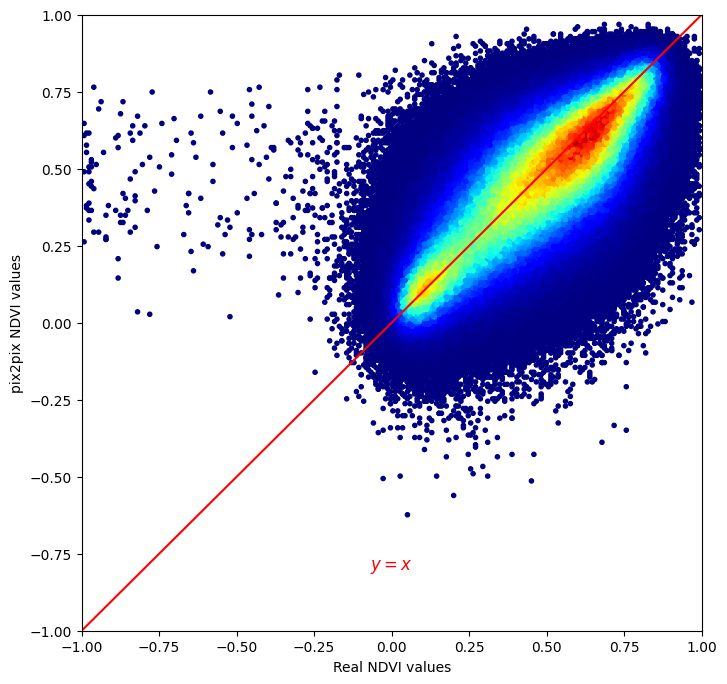

In [85]:
x = df["ndvi_true"].tolist()
y = df["ndvi_est"].tolist()
#histogram definition
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])


fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x, y, c=z, cmap='jet', marker='.')

# Plot the perfect line passing through (-1, -1) and (1, 1)
ax.plot([-1, 1], [-1, 1], color='red', label='Perfect Line (y = -x)')

ax.text(0, -0.8, r'$ y = x $', color='red', fontsize=12, ha='center')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

ax.set_xlabel('Real NDVI values')
ax.set_ylabel('pix2pix NDVI values')

plt.savefig("figures/scatter_density.png", dpi =300)
plt.show()

In [84]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(x,y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

R-squared: 0.5795605252904321
Mean Squared Error: 0.01935694774088971
Root Mean Squared Error: 0.13912924833006793


## 2. Epoch improvement plotting

1. IMPORT ALL TIMESTEPS

In [11]:
#Reconstruct an epoch that has passed thorugh p2p
def load_p2p_from_folder(sub):
    folder = os.path.join("rgb_ndvi_p2p", sub, "images")
    fakeb = "fake_B"       
    imgs = [os.path.join(img) for img in os.listdir(folder)]
    fake_b = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]
    fake_b_arr = [image_to_numpy_array(file) for file in fake_b]
    # FOR P2P NDVI
    ndvi_p2p_list = [np_chip_to_rxr(fake_b_arr[i], row, test.crs).sel(band=0) for i, row in test.iterrows()]
    #add the empty_rgb to the list
    ndvi_p2p = merge.merge_arrays([empty_ndvi] + ndvi_p2p_list)   
    
    # Clip to test-area to reduce array size
    ndvi_p2p = ndvi_p2p.rio.clip_box(minx = test.bounds.min().minx, miny =test.bounds.min().miny ,maxx =test.bounds.max().maxx , maxy= test.bounds.max().maxy) 
    # Scale ndvi to -1 : 1 
    ndvi_p2p = ndvi_p2p.where(ndvi_p2p>0)
    ndvi_p2p = (ndvi_p2p/127.5)-1

    return ndvi_p2p

p2p_e1 = load_p2p_from_folder("test_1")
p2p_e5 = load_p2p_from_folder("test_5")
p2p_e10 = load_p2p_from_folder("test_10")
p2p_e25 = load_p2p_from_folder("test_25")
p2p_e50 = load_p2p_from_folder("test_50")
p2p_e100 = load_p2p_from_folder("test_100")
p2p_e200 = load_p2p_from_folder("test_200")



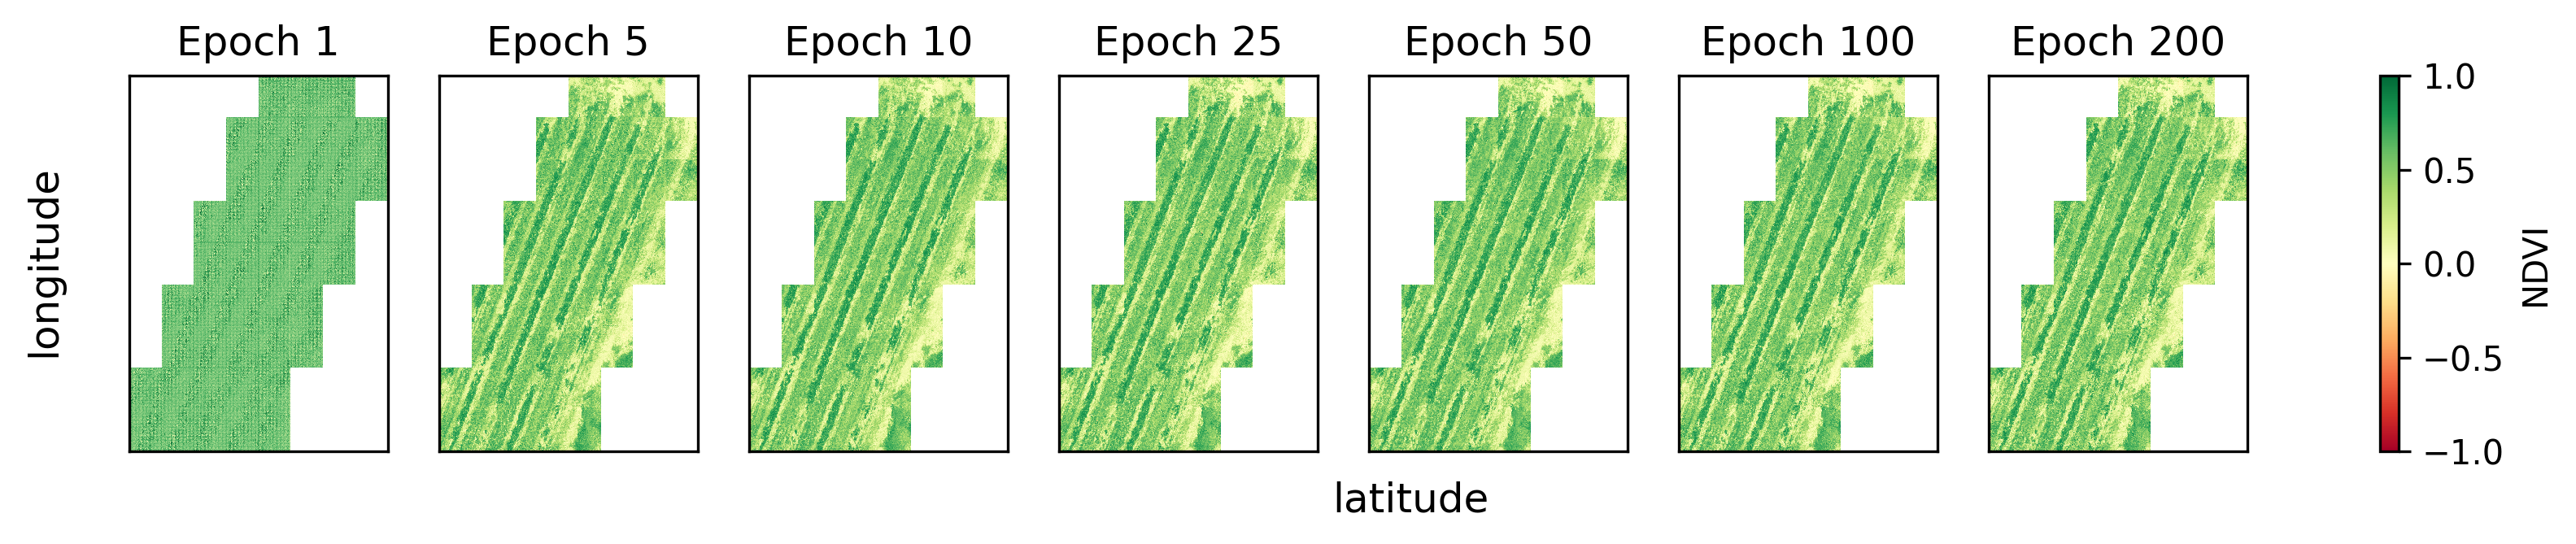

In [12]:
fig,ax = plt.subplots(dpi=300, nrows= 1, ncols = 7, figsize= (14,2))


im0 = p2p_e1.plot(ax=ax[0], cmap ="YlGn", vmin=-1, vmax=1,add_colorbar=False)
ax[0].set_title("Epoch 1")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("")

im1 = p2p_e5.plot(ax=ax[1], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[1].set_title("Epoch 5")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("")


im2=p2p_e10.plot(ax=ax[2], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[2].set_title("Epoch 10")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("")


im3 =p2p_e25.plot(ax=ax[3], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[3].set_title("Epoch 25")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("")


im4=p2p_e50.plot(ax=ax[4], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[4].set_title("Epoch 50")
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_xlabel("")
ax[4].set_ylabel("")


im5=p2p_e100.plot(ax=ax[5], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[5].set_title("Epoch 100")
ax[5].set_xticks([])
ax[5].set_yticks([])
ax[5].set_xlabel("")
ax[5].set_ylabel("")


im6=p2p_e200.plot(ax=ax[6], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[6].set_title("Epoch 200")
ax[6].set_xticks([])
ax[6].set_yticks([])
ax[6].set_xlabel("")
ax[6].set_ylabel("")

# Add a colorbar to the Figure using fig.colorbar()
cbar = fig.colorbar(im6, ax=ax, orientation='vertical', label ="NDVI")

# Add x and y axis labels to the main Figure
fig.text(0.5, 0.01, 'latitude', ha='center', va='center', fontsize=12)
fig.text(0.1, 0.5, 'longitude', ha='center', va='center', rotation='vertical', fontsize=12)
#plt.tight_layout()
plt.savefig("figures/epochs.png", dpi=300)
plt.show()

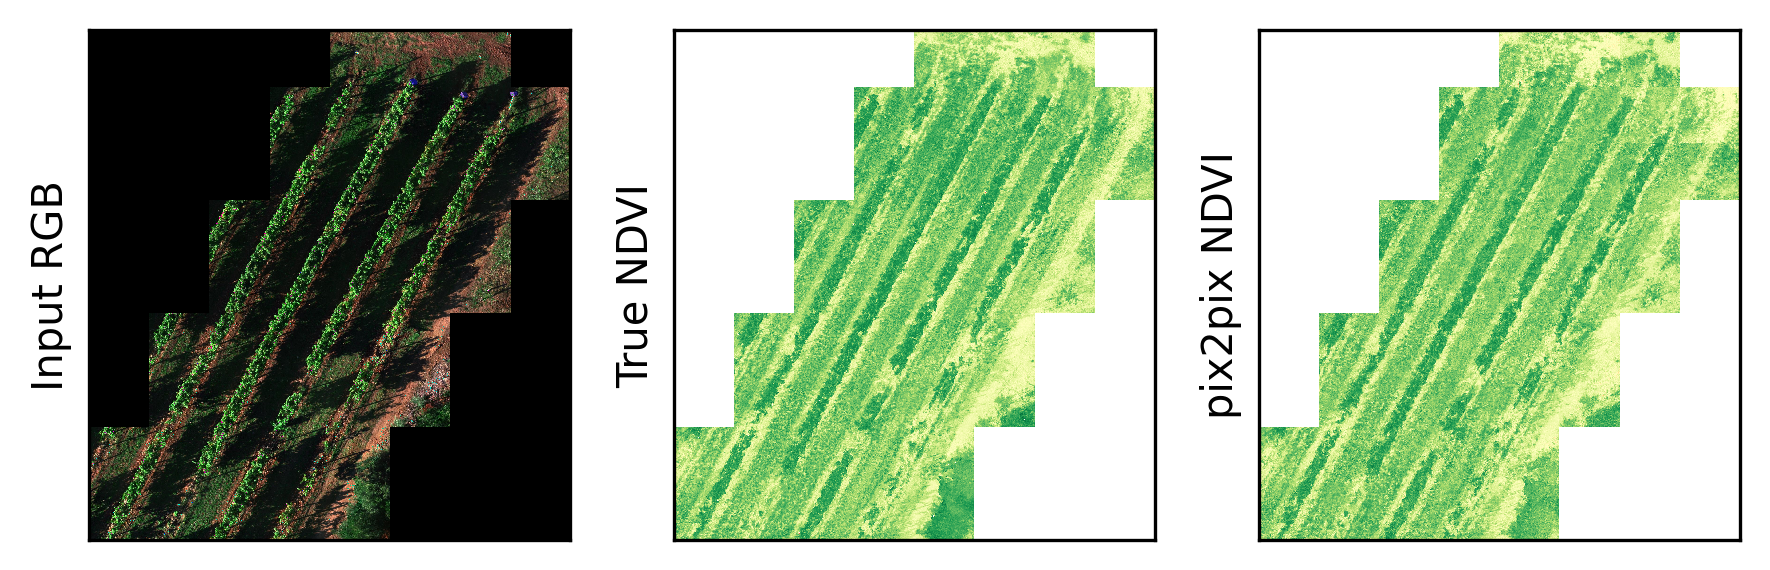

In [13]:
fig,ax = plt.subplots(figsize=(6,2),nrows =1, ncols = 3,dpi=300)

rgb_test.plot.imshow(ax=ax[0])
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("Input RGB")
im0=ndvi_test.plot(ax=ax[1], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("True NDVI")


im1=p2p_e200.plot(ax=ax[2], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pix NDVI")

plt.tight_layout()
plt.savefig("figures/comparison.png")
plt.show()

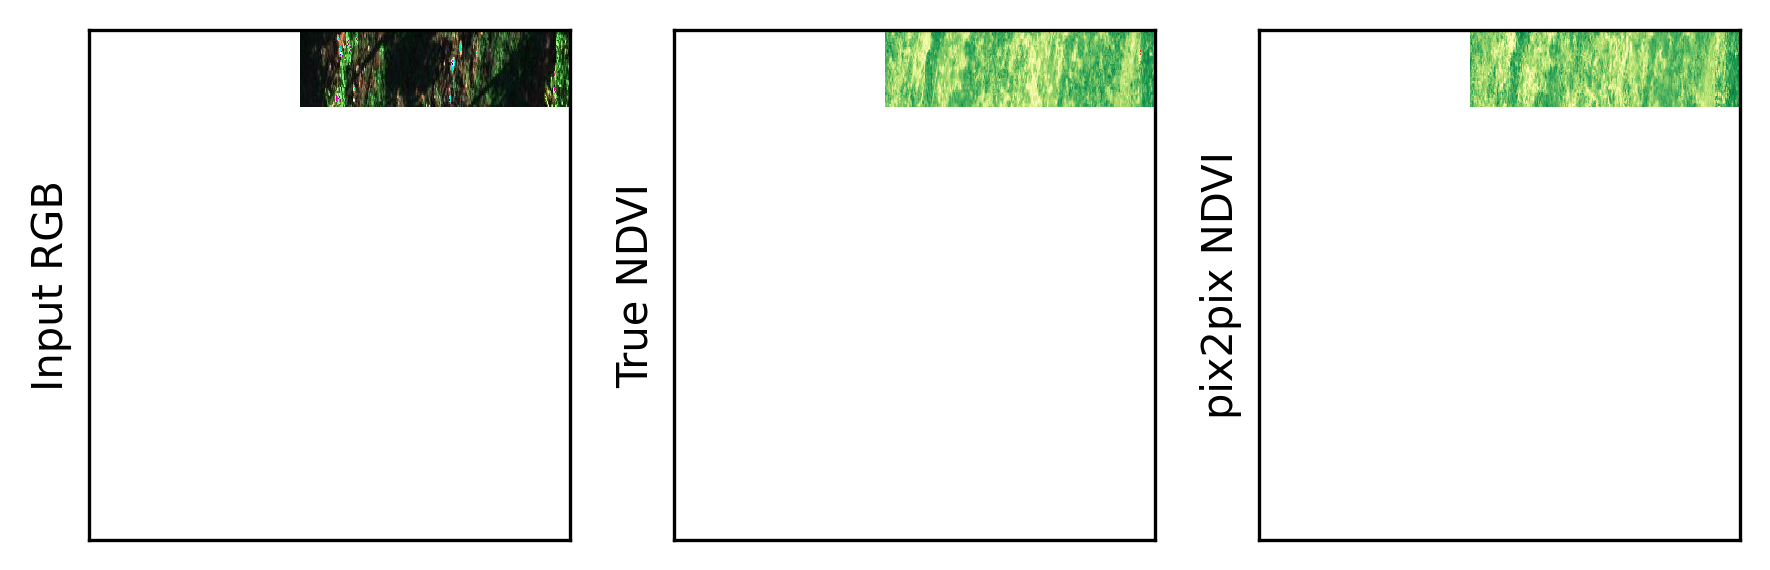

In [18]:
# to do the same as above, but zoomed in to a specific spot.
ylims =  (4644825.376,4644830.877)
xlims = (517005.855,517022.702)

fig,ax = plt.subplots(figsize=(6,2),nrows =1, ncols = 3,dpi=300)


rgb_test.plot.imshow(ax=ax[0])
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("Input RGB")
ax[0].set_ylim(ylims)
ax[0].set_xlim(xlims)

im0=ndvi_test.plot(ax=ax[1], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("True NDVI")
ax[1].set_ylim(ylims)
ax[1].set_xlim(xlims)

im1=p2p_e200.plot(ax=ax[2], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pix NDVI")
ax[2].set_ylim(ylims)
ax[2].set_xlim(xlims)

plt.tight_layout()
plt.savefig("figures/comparison_zoomed.png")
plt.show()